In [2]:
#------ manually fix import for now
import sys
sys.path.append('..')
#------

import numpy as np
import astropy.units as u
from redexo import *
import matplotlib.pyplot as plt
import copy

Loading 94 files...
(array([21, 22, 23, 24, 25, 26, 27, 59, 68, 71, 74, 76, 77, 78, 79, 80, 81,
       82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93]),)
[21 22 23 24 25 26 27 59 68 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 89 90 91 92 93]


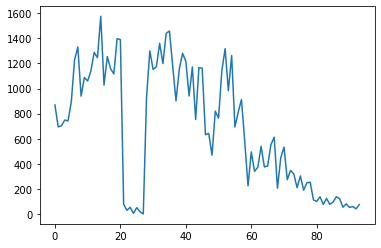

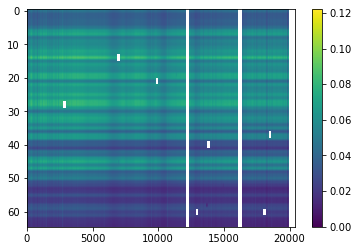

In [3]:
dataset = load_carmenes_data(folder='/users/ricolandman/Research_data/OH_exoplanets/WASP189_carmenes/',\
                            spectral_orders=[23,24,25,26,27])


tot_I = np.nansum(dataset.spec, axis=(1,2))
print(np.where(tot_I<300))
dataset.drop_exposures(np.where(tot_I<300)[0])
plt.plot(tot_I)
plt.show()
plt.imshow(dataset.spec.reshape(dataset.num_exposures,-1),aspect='auto',vmin=0)
plt.colorbar()
plt.show()

In [4]:
planet = Planet(Kp=185, vsys=-1.1, T0=2458926.5416960, orbital_period=2.7240330)
planet.transit_start = 0.01

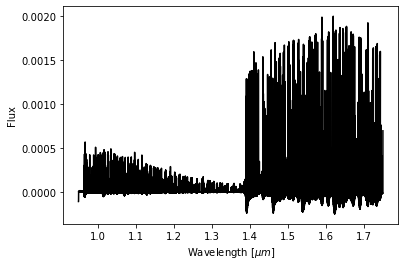

In [5]:
template_wl, template = np.load('/users/ricolandman/Research_data/OH_exoplanets/models/Wasp76_OH_equilibrium_T=2900K_prepared.npy')
template = 1-template
plt.plot(template_wl/1e4, template, color='black')
plt.xlabel(r'Wavelength [$\mu m$]')
plt.ylabel('Flux')
plt.show()

1.1111112798037348


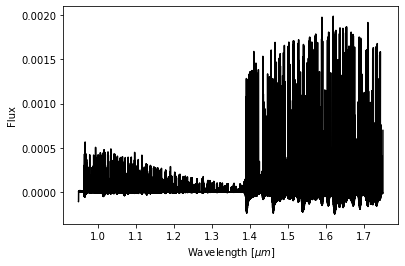

In [6]:
from scipy.ndimage import gaussian_filter1d
model_res = np.mean(template_wl)/np.mean(np.diff(template_wl))
model_dv = 3e5/model_res
dpix =  1./model_dv
print(dpix)
broad_template = gaussian_filter1d(template, dpix/(2*np.sqrt(2*np.log(2))))
plt.plot(template_wl/1e4, broad_template, color='black')
plt.xlabel(r'Wavelength [$\mu m$]')
plt.ylabel('Flux')
plt.show()

In [7]:
pipeline = Pipeline()

#pipeline.add_module( InjectSignalModule(template=template, template_wl=template_wl, target=planet, savename='injection') )

pipeline.add_module( FlagAbsorptionEmissionModule(flux_lower_limit=0.4, flux_upper_limit=1.4, 
                                                    relative_to_continuum=True) )
pipeline.add_module( PolynomialContinuumRemovalModule(poly_order=3))
#pipeline.add_module( SavGolContinuumRemovalModule(window_length=1001, poly_order=3))


pipeline.add_module( OutlierFlaggingModule(sigma=5) )

pipeline.add_module( SysRemModule(number_of_modes=3, mode='subtract', name='cleaned') )
#pipeline.add_module( PCASubtractModule(number_of_modes=9))

pipeline.add_module( CrossCorrelationModule(template = broad_template, template_wl = template_wl, 
                                            rv_range=600, drv=1.3, error_weighted=True, name='ccf'))
pipeline.add_module( CoAddOrders(name='co_added', weights=None))
pipeline.add_module( ShiftRestFrameModule(target=planet, name='CCF_map_planet'))
pipeline.add_module( CoAddExposures(name='1D_CCF', weights=planet.in_transit(dataset.obstimes)))

In [8]:
pipeline.run(dataset, num_workers=5, per_order=True) 
pipeline.summary()

/Users/ricolandman/miniforge3/envs/mypython/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/ricolandman/miniforge3/envs/mypython/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/ricolandman/miniforge3/envs/mypython/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


----------Summary--------
Running <redexo.modules.cleaning.FlagAbsorptionEmissionModule object at 0x10b774df0> took 0.25 seconds
Running <redexo.modules.cleaning.PolynomialContinuumRemovalModule object at 0x1336ff490> took 0.32 seconds
Running <redexo.modules.cleaning.OutlierFlaggingModule object at 0x1336ff3d0> took 0.22 seconds
Running <redexo.modules.telluric_correction.SysRemModule object at 0x1336ff430> took 0.39 seconds
Running <redexo.modules.cross_correlation.CrossCorrelationModule object at 0x1336ff4f0> took 5.05 seconds
Running <redexo.modules.util.CoAddOrders object at 0x1336ff340> took 0.00 seconds
Running <redexo.modules.util.ShiftRestFrameModule object at 0x1115cb850> took 0.01 seconds
Running <redexo.modules.util.CoAddExposures object at 0x1336ffd60> took 0.00 seconds
--> Total time: 6.24 seconds
------------------------


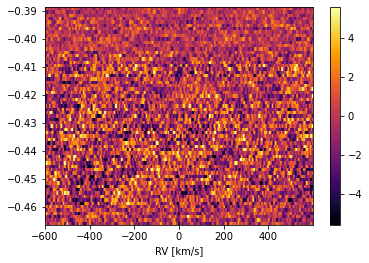

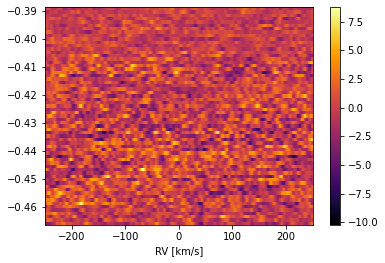

In [9]:
ccf_map_earth = pipeline.get_results('co_added')
ccf_map_planet = pipeline.get_results('CCF_map_planet')
ccf = pipeline.get_results('1D_CCF')

phases = planet.orbital_phase(dataset.obstimes)
vmax = np.percentile(ccf_map_earth.spec, 99.6)
plt.figure()
plt.imshow(ccf_map_earth.spec[:,0,:], aspect='auto', cmap='inferno', origin='lower', 
           extent=[ccf_map_earth.rv_grid.min(), ccf_map_earth.rv_grid.max(),min(phases),max(phases)],
            vmin =-vmax, vmax=vmax, interpolation='none')
#plt.xlim(-250,250)
plt.colorbar()
plt.xlabel('RV [km/s]')
plt.show()


plt.figure()
plt.imshow(ccf_map_planet.spec[:,0,:], aspect='auto', cmap='inferno', origin='lower', 
           extent=[ccf_map_planet.rv_grid.min(), ccf_map_planet.rv_grid.max(),min(phases),max(phases)],
            interpolation='none')
plt.xlim(-250,250)
plt.colorbar()
plt.xlabel('RV [km/s]')
plt.show()

In [10]:
Kp_list = np.arange(150,250, 1.3)
snr_map = make_kp_vsys_map(ccf_map_earth, Kp_list, planet)
print('SNR:', np.max(snr_map))

fig, axes = plt.subplots(nrows=3, ncols=2, sharex='col',
                           gridspec_kw={'height_ratios': [1,1, 3],
                            'width_ratios':[20,1]},
                           figsize=(6, 7.5))

rv_grid = ccf_map_earth.rv_grid
plt.sca(axes[2,0])
im= plt.imshow( snr_map, extent=[np.min(rv_grid),np.max(rv_grid), np.min(Kp_list), np.max(Kp_list)],origin='lower',
    cmap='gist_heat', interpolation='none', aspect='auto')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-80,80)
plt.ylim(-50,350)
plt.xlabel(r'$v_{\mathrm{rest}}$ [km/s]', fontsize=14)
plt.ylabel(r'$K_p$ [km/s]', fontsize=14)
cbar = fig.colorbar(im,cax=axes[2,1])
cbar.set_label(label='Signal-to-noise ratio', size='large')
cbar.ax.tick_params(labelsize=12) 
plt.xlim(-250,250)

max_kp_index= np.where(snr_map==snr_map.max())[0][0]
#max_kp_index = np.argmin(np.abs(Kp_list.value-234))
max_kp = Kp_list[max_kp_index]
true_kp_index = np.argmin(np.abs(Kp_list-185))
ccf = snr_map[max_kp_index]
ccf2 = snr_map[true_kp_index]


plt.sca(axes[0,0])
plt.plot(rv_grid[0,0], ccf2, color='black')
plt.title('Kp=196.5 km/s', fontsize=12)
plt.yticks([-2,0,2,4,6],fontsize=12)
plt.grid()
plt.axhline(0, color='black', ls='--',alpha=0.6)
plt.ylabel('SNR',fontsize=12)


plt.sca(axes[1,0])
plt.plot(rv_grid[0,0], ccf, color='black')
plt.title('Kp={0:.1f} km/s'.format(max_kp), fontsize=12)
plt.axhline(0, color='black', ls='--',alpha=0.6)
mask = (rv_grid<10)*(rv_grid>-30)
plt.grid()
plt.ylabel('SNR',fontsize=12)
plt.yticks([-2,0,2,4,6],fontsize=12)
#plt.xticks([])
plt.sca(axes[0,1])
plt.axis('off')
plt.sca(axes[1,1])
plt.axis('off')
plt.tight_layout()

TypeError: object of type 'int' has no len()